In [1]:
from scipy.stats import nbinom, binom, poisson
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import seaborn as sns
from datetime import datetime, timedelta
from scipy.stats import pearsonr
from scipy.stats import kendalltau
from scipy.stats import spearmanr
import os
from scipy.optimize import minimize, Bounds
import inspect
from scipy.stats import poisson
from scipy.stats import chisquare
import statsmodels as sm
from scipy.optimize import minimize

In [2]:
path = x
filename = 'Pivot_Trans_Privat_ohneApple_Langzeitkunde.csv'

df_trans_werte = pd.read_csv(os.path.join(path, filename))

In [3]:
df_trans_werte.head()

,iid,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,100056041,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,100057957,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,100059553,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100062565,4.0,0.0,1.0,3.0,2.0,1.0,1.0,2.0,1.0,1.0,0.0,1.0,2.0,3.0,0.0
4,100062713,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


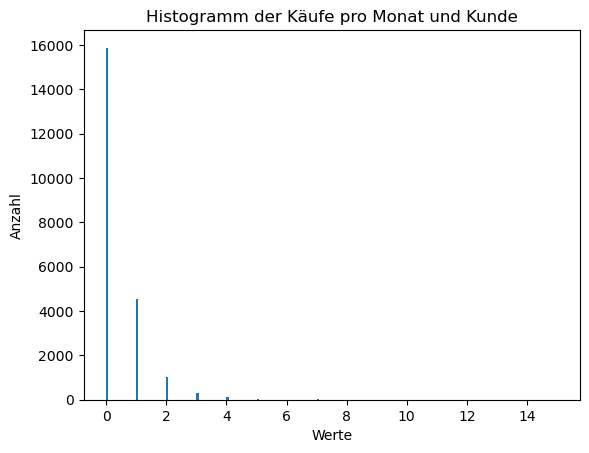

In [7]:
# Alle Spalten auswählen außer 'iid'
columns_to_plot = df_trans_werte.columns[df_trans_werte.columns != 'iid']

# Histogramm erstellen
plt.hist(df_trans_werte[columns_to_plot].values.flatten(), bins="auto")
plt.xlabel('Werte')
plt.ylabel('Anzahl')
plt.title('Histogramm der Käufe pro Monat und Kunde')
plt.savefig("C:/Users/felix.oechslein/Desktop/Analysen Thalia, Mai/Grafiken/" +
            'Histogramm_käufe.png', dpi=300)
plt.show()

In [8]:
data = df_trans_werte[columns_to_plot].values.flatten()
data

array([1., 0., 0., ..., 0., 0., 0.])

# Definition der Daten und Ermittlung der empirischen cdf

In [9]:
int_data = data.astype(int)

In [10]:
ecdf = sm.distributions.ECDF(int_data)

In [11]:
ecdf(int_data)

array([0.93173735, 0.72412221, 0.72412221, ..., 0.72412221, 0.72412221,
       0.72412221])

# Optimierung ZINBD

In [12]:
def my_distribution_ZINBD(y, phi, lambdaY, r):
    cdf = np.zeros_like(y, dtype=float)
    if r > 0:
        for i in range(len(y)):
            for j in range(y[i] + 1):
                if j == 0:
                    pmf = phi + (1 - phi) * (1 + lambdaY / r)**(-r)
                elif j > 0:
                    numerator = math.gamma(j + r)
                    denominator = math.factorial(j) * math.gamma(r)
                    gamma_term = numerator / denominator
                    pmf= (1 - phi) * gamma_term * (1 + lambdaY / r)**(-r) * (1 + r / lambdaY)**(-j)
                cdf[i] += pmf
    return cdf

# Funktion zur Berechnung der Summe der quadratischen Abweichungen
def squared_error(params):
    phi, lambdaY, r = params
    predicted_values = my_distribution_ZINBD(int_data, phi, lambdaY, r)
    error = ecdf(int_data) - predicted_values
    squared_error = np.sum(error**2)
    return squared_error

# Anfangsschätzwerte für die Parameter
initial_guess = [1, 1, 1.5]
# Grenzen (Bounds)
bounds = [(0, 1), (0, 9999), (0,10)]


# Parameter schätzen
result = minimize(squared_error, initial_guess, bounds=bounds, method = "L-BFGS-B")

# Geschätzte Parameter auslesen
estimated_params_ZINBD = result.x

# Ergebnis ausgeben
print("Geschätzte Parameter:", estimated_params_ZINBD)
print(result.success)

Geschätzte Parameter: [0.         0.36653535 1.29445745]
True


# Optimierung NBD

In [13]:
# Funktion zur Berechnung der Summe der quadratischen Abweichungen
def squared_error_nbinom(params):
    n, p = params
    predicted_values = nbinom.cdf(int_data, n, p)
    error = ecdf(int_data) - predicted_values
    squared_error = np.sum(error**2)
    return squared_error

# Anfangsschätzwerte für die Parameter
initial_guess = [3, 0.3]
# Grenzen (Bounds)
bounds = [(0, 9999), (0, 9999)]

# Parameter schätzen
result = minimize(squared_error_nbinom, initial_guess, bounds=bounds, method = "Nelder-Mead")

# Geschätzte Parameter auslesen
estimated_params_NBD = result.x

# Ergebnis ausgeben
print("Geschätzte Parameter:", estimated_params_NBD)
print(result.success)

Geschätzte Parameter: [1.2944842  0.77933162]
True


# Optimierung Poisson

In [14]:
from scipy.stats import poisson

# Funktion zur Berechnung der Summe der quadratischen Abweichungen
def squared_error_poisson(params):
    mu = params
    predicted_values = poisson.cdf(int_data, mu)
    error = ecdf(int_data) - predicted_values
    squared_error = np.sum(error**2)
    return squared_error

# Anfangsschätzwerte für die Parameter
initial_guess = [0.3]
# Grenzen (Bounds)
bounds = [(0, 9999)]

# Parameter schätzen
result = minimize(squared_error_poisson, initial_guess, bounds=bounds, method = "L-BFGS-B")

# Geschätzte Parameter auslesen
estimated_params_poisson = result.x

# Ergebnis ausgeben
print("Geschätzte Parameter:", estimated_params_poisson)
print(result.success)

Geschätzte Parameter: [0.32615484]
True


# Grafischer Vergleich mit optimierten Parametern

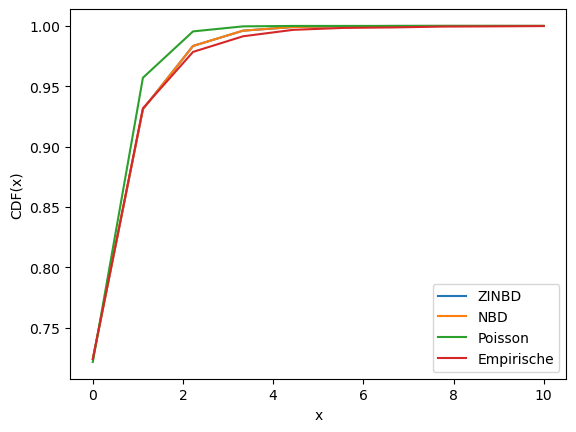

In [18]:
# Definitionsbereich der CDF
x_values = np.linspace(0, 10, 10).astype(int)

# Daten für ZINBD
x1 = np.linspace(0, 10, 10)
y1 = my_distribution_ZINBD(x_values, estimated_params_ZINBD[0], estimated_params_ZINBD[1], estimated_params_ZINBD[2])

# Daten für NBD
x2 = np.linspace(0, 10, 10)
y2 = nbinom.cdf(x_values, estimated_params_NBD[0], estimated_params_NBD[1])

# Daten für Poisson
x3 = np.linspace(0, 10, 10)
y3 = poisson.cdf(x_values, estimated_params_poisson[0])

# Daten für Empirische
x4 = np.linspace(0, 10, 10)
y4 = ecdf(x2)

# Plot der ersten CDF
plt.plot(x1, y1, label='ZINBD')

# Plot der zweiten CDF
plt.plot(x2, y2, label='NBD')

# Plot der ersten CDF
plt.plot(x3, y3, label='Poisson')

# Plot der zweiten CDF
plt.plot(x4, y4, label='Empirische')


# Achsentitel und Legende hinzufügen
plt.xlabel('x')
plt.ylabel('CDF(x)')
plt.legend()
plt.show()

# Chi Quadrat Tests

In [16]:
# Maximaler Eintrag von int_data
max_value = np.max(np.unique(int_data))

# Array erstellen
array = np.arange(max_value + 1)

## Datensimulation ZINBD

In [56]:
test = np.histogram(my_distribution_ZINBD(int_data, estimated_params_ZINBD[0], estimated_params_ZINBD[1], estimated_params_ZINBD[2]))

In [57]:
test= my_distribution_ZINBD(array, estimated_params_ZINBD[0], estimated_params_ZINBD[1], estimated_params_ZINBD[2])
test

array([0.72416275, 0.93102064, 0.98338915, 0.99607972, 0.99908633,
       0.99978888, 0.99995152, 0.99998892, 0.99999748, 0.99999943,
       0.99999987, 0.99999997, 0.99999999, 1.        , 1.        ,
       1.        ])

In [58]:
test_prob = np.zeros(max_value)

for i in range(0, max_value):
    if i == 0:
        test_prob[i] = test[i]
    else:
        test_prob[i] = test[i] - test[i-1]
        
test_prob

array([7.24162755e-01, 2.06857886e-01, 5.23685096e-02, 1.26905657e-02,
       3.00661219e-03, 7.02549600e-04, 1.62641796e-04, 3.74003130e-05,
       8.55699647e-06, 1.95007362e-06, 4.42998840e-07, 1.00374500e-07,
       2.26934037e-08, 5.12123877e-09, 1.15388565e-09])

In [59]:
hist_dist = test_prob * len(int_data)
hist_dist_int = hist_dist.astype(int)
hist_dist_int[0] += 5

## Anpassung beobachtete Werte

In [66]:
observed_freq = np.histogram(int_data, bins=array)[0]

In [67]:
observed_freq

array([15880,  4553,  1025,   284,   117,    35,     9,    15,     4,
           4,     1,     2,     0,     0,     1], dtype=int64)

## Chi Quadrat Test ZINBD

In [64]:
# Null-Werte durch Einsen ersetzen
hist_dist_int = np.where(hist_dist_int == 0, 1, hist_dist_int)

In [70]:
# Test ob gleichviele Werte i beiden ethalten sind
print("hist_dist Werte" + " " + str(np.sum(hist_dist_int)))
print("empirische Werte" + " " + str(np.sum(observed_freq)))

hist_dist Werte 21938
empirische Werte 21930


In [71]:
hist_dist_int[0] -= 8

In [72]:
# Chi-Quadrat-Test
chi2, p_value = chisquare(f_obs=observed_freq, f_exp=hist_dist_int, ddof=0)

# Ergebnis ausgeben
print("Chi-Quadrat-Wert:", chi2)
print("p-Wert:", p_value)

Chi-Quadrat-Wert: 310.63901387788036
p-Wert: 7.122179633502471e-58


## Chi Quadrat Test Poisson

In [73]:
# Poisson-Zufallsvariablen erzeugen
poisson_data = poisson.rvs(mu=estimated_params_poisson, size=len(int_data))

In [74]:
test_poisson = np.histogram(poisson_data, bins = array)[0]

In [76]:
# Null-Werte durch Einsen ersetzen
test_poisson = np.where(test_poisson == 0, 1, test_poisson)

In [78]:
# Test ob gleichviele Werte i beiden ethalten sind
print("Verteilung Werte" + " " + str(np.sum(test_poisson)))
print("empirische Werte" + " " + str(np.sum(observed_freq)))

Verteilung Werte 21938
empirische Werte 21930


In [79]:
test_poisson[0] -= 8

In [80]:
# Chi-Quadrat-Test
chi2, p_value = chisquare(f_obs=observed_freq, f_exp=test_poisson, ddof=0)

# Ergebnis ausgeben
print("Chi-Quadrat-Wert:", chi2)
print("p-Wert:", p_value)

Chi-Quadrat-Wert: 2220.081662395682
p-Wert: 0.0


## Chi Quadrat Test NBD

In [81]:
# NBD-Zufallsvariablen erzeugen
NBD_data = nbinom.rvs(estimated_params_NBD[0], estimated_params_NBD[1], size=len(int_data))

In [84]:
test_NBD = np.histogram(NBD_data, bins = array)[0]

In [85]:
# Null-Werte durch Einsen ersetzen
test_NBD = np.where(test_NBD == 0, 1, test_NBD)

In [86]:
# Test ob gleichviele Werte i beiden ethalten sind
print("Verteilung Werte" + " " + str(np.sum(test_NBD)))
print("empirische Werte" + " " + str(np.sum(observed_freq)))

Verteilung Werte 21938
empirische Werte 21930


In [87]:
test_NBD[0] -= 8

In [88]:
# Chi-Quadrat-Test
chi2, p_value = chisquare(f_obs=observed_freq, f_exp=test_NBD, ddof=2)

# Ergebnis ausgeben
print("Chi-Quadrat-Wert:", chi2)
print("p-Wert:", p_value)

Chi-Quadrat-Wert: 306.39984889956196
p-Wert: 2.1258996228406985e-58
